In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing

# use seaborn plotting defaults
import seaborn as sns; sns.set()


features = pd.read_csv("../data/new_labeled_features.csv",index_col=0)
tfeatures = features.T







## Select K Best for feature selection, after normalization/scaling

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

norm_list = [Normalizer(), StandardScaler(with_mean=False), MinMaxScaler()]
selK = SelectKBest(f_classif, k=4)
tnfeatures = norm_list[0].transform(tfeatures.iloc[:28, :])
nfeatures = tnfeatures.T
selK.fit(nfeatures, features.iloc[:, -1])
print("SELECT K BEST NUMBERS:")
print(selK.get_support())
print(selK.scores_[selK.get_support()])
for norm in norm_list[1:]:
    nfeatures = norm.fit_transform(features.iloc[:, :28])
    selK.fit(nfeatures, features.iloc[:, -1])
    print("\n\nSELECT K BEST NUMBERS:")
    print(selK.get_support())
    print(selK.scores_[selK.get_support()])







## Select K Best for all 4 signals, after normalization

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Normalizer

norm = Normalizer()
selK = SelectKBest(f_classif, k=4)
col = features.columns
for i in range(4):
    tnfeatures = norm.transform(tfeatures.iloc[i*28:(i+1)*28, :])
    nfeatures = tnfeatures.T
    selK.fit(nfeatures, features.iloc[:, -1])
    print("\n\nSELECT K BEST NUMBERS FOR signal %d:"%(i))
    print(selK.get_support())
    print(selK.scores_[selK.get_support()])
    feat = col[i*28:(i+1)*28]
    print(feat[selK.get_support()])



SELECT K BEST NUMBERS FOR signal 0:
[False False False False False False False False False False  True False
 False False False False  True  True  True False False False False False
 False False False False]
[330.9079015  422.54146593 335.18651221 382.78688292]
Index(['10', '16', '17', '18'], dtype='object')


SELECT K BEST NUMBERS FOR signal 1:
[False False False False False False False False False False False False
 False  True  True False False False False False False  True  True False
 False False False False]
[311.06969737 306.34495183 356.91090893 321.01200709]
Index(['41', '42', '49', '50'], dtype='object')


SELECT K BEST NUMBERS FOR signal 2:
[False False False False False False False False False False  True False
 False False False False  True  True  True False False False False False
 False False False False]
[329.72298115 422.36009666 335.43952703 382.80602317]
Index(['66', '72', '73', '74'], dtype='object')


SELECT K BEST NUMBERS FOR signal 3:
[False False False False F







## feature selection for the 4 normalized signals, using RFECV with Logistic Regression

Optimal number of features : 17


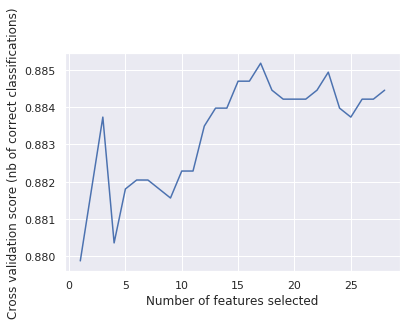

rfecv ranking:
[ 1  1  5  1  1  1  1  1  1  6  4  3  2  1  9  7  1  1  1  8  1  1 10 12
  1  1 11  1]
Index(['0', '1', '3', '4', '5', '6', '7', '8', '13', '16', '17', '18', '20',
       '21', '24', '25', '27'],
      dtype='object')


Optimal number of features : 7


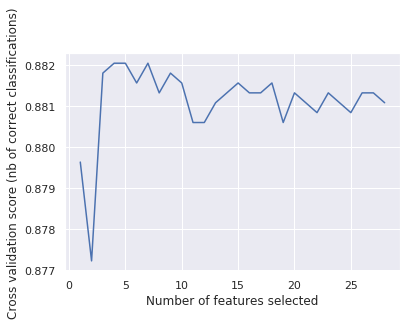

rfecv ranking:
[ 2  1  5  4  1  6  1  3 17 16 21 20 11  1 13 18 12 14  8  7  1  1  1 19
 15 22 10  9]
Index(['29', '32', '34', '41', '48', '49', '50'], dtype='object')


Optimal number of features : 13


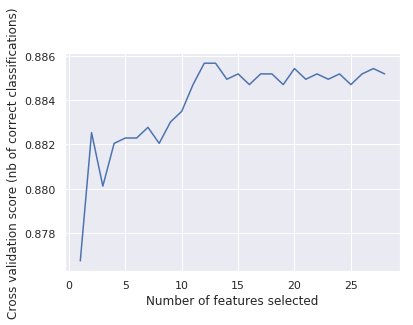

rfecv ranking:
[ 1  1  1  8 10  7  1  1  1  5 12  4  1  1  2 14  1  1  1 13  3  6 16 15
  9  1  1 11]
Index(['56', '57', '58', '62', '63', '64', '68', '69', '72', '73', '74', '81',
       '82'],
      dtype='object')


Optimal number of features : 28


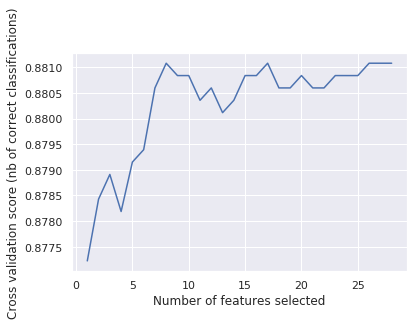

rfecv ranking:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Index(['84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95',
       '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111'],
      dtype='object')




In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

estimators_list = [LogisticRegression(C=1000, tol=0.001)]
col = features.columns
norm = Normalizer()
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
for i in range(4):
    for est in estimators_list:
        rfecv = RFECV(estimator=est, step=1, cv=StratifiedKFold(5),scoring='accuracy')
        tnfeatures = norm.transform(tfeatures.iloc[i*28:(i+1)*28, :])
        nfeatures = tnfeatures.T
        rfecv.fit(nfeatures, features.iloc[:, -1])

        print("Optimal number of features : %d" % rfecv.n_features_)

        # Plot number of features VS. cross-validation scores
        fig = plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()
        print("rfecv ranking:")
        print(rfecv.ranking_)
        feat = col[i*28:(i+1)*28]
        print(feat[rfecv.get_support()])
    print()
    print()







## The features set as important for each normalized signal by 2 ensemble classifiers

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import Normalizer

ensemble_list = [ExtraTreesClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100)]
col = features.columns

for i in range(4):
    tnfeatures = Normalizer().transform(tfeatures.iloc[i*28:(i+1)*28, :])
    nfeatures = tnfeatures.T
    for est in ensemble_list:
        featureSelection = SelectFromModel(est, threshold=0.035714285714285)
        featureSelection.fit(nfeatures, features.label)
        selectedFeatures = featureSelection.transform(nfeatures)
        feat = col[i*28:(i+1)*28]
        print(feat[featureSelection.get_support()])
    print("\n\n")


Index(['0', '1', '3', '8', '9', '10', '16', '17', '18', '24', '25', '27'], dtype='object')
Index(['0', '3', '8', '10', '16', '17', '18', '24', '25', '27'], dtype='object')



Index(['28', '29', '30', '31', '33', '34', '40', '41', '42', '48', '49', '50'], dtype='object')
Index(['28', '29', '30', '31', '33', '34', '41', '42', '48', '49', '50'], dtype='object')



Index(['57', '64', '65', '66', '72', '73', '74', '81'], dtype='object')
Index(['64', '65', '66', '72', '73', '74', '81', '82'], dtype='object')



Index(['89', '90', '96', '97', '98', '104', '105', '106'], dtype='object')
Index(['89', '90', '97', '98', '104', '105', '106'], dtype='object')





# TESTS

In [12]:
# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
# fit an Extra Trees model to the data
ensemble_list = [ExtraTreesClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100)]
for est in ensemble_list:
    est.fit(features.iloc[:, :28], features["label"])
# display the relative importance of each attribute
    print(est.feature_importances_)

[0.06427025 0.04069783 0.02879415 0.04886765 0.02303449 0.02446383
 0.02359162 0.02511599 0.07020633 0.04157194 0.04752355 0.02369311
 0.01777545 0.01735526 0.01751683 0.01744964 0.0749474  0.06488946
 0.06981913 0.01820568 0.00974844 0.00918412 0.01703956 0.01748193
 0.05427083 0.05949569 0.02729965 0.04569021]
[0.08346166 0.02552994 0.02869594 0.03830917 0.04736252 0.02834501
 0.0226708  0.0270094  0.1030324  0.03674292 0.05517888 0.02814528
 0.01589802 0.01516755 0.01863713 0.01624966 0.05361549 0.07076341
 0.08003661 0.02018685 0.00196541 0.00255725 0.01005125 0.00802656
 0.06518618 0.03334718 0.0231808  0.04064673]


In [18]:
# Recursive Feature Elimination
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe.fit(features.iloc[:, :28], features["label"])
# summarize the selection of the attributes
print("RFE NUMBERS:")
print(rfe.ranking_)

model = SVC(kernel="linear")
rfe = RFE(model, 3)
rfe.fit(features.iloc[:, :28], features["label"])
print("RFE NUMBERS:")
print(rfe.ranking_)

#RFE model with Cross Validation
#, scoring='accuracy'

model = SVC(kernel="linear")
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2))
rfecv.fit(features.iloc[:, :28], features["label"])
print("\n\nRFECV NUMBERS:")
print(rfecv.n_features_)
print(rfecv.ranking_)
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2))
rfecv.fit(features.iloc[:, :28], features["label"])
print("RFECV NUMBERS:")
print(rfecv.n_features_)
print(rfecv.ranking_)



selK = SelectKBest(f_classif, k=6)
selK.fit(features.iloc[:, :28], features["label"])
print("\n\nSELECT K BEST NUMBERS:")
print(selK.get_support())
print(selK.scores_)

RFE NUMBERS:
[ 3  4 11 16 12 10 15 14  2  1  8 17 21 22 20 19  1  1  7 18 25 26 24 23
  6  5  9 13]
RFE NUMBERS:
[ 5 11 10 13 17 15 14 12  1  2  4  9 22 21 19 20  1  1  3 18 25 26 24 23
  8  7 16  6]


RFECV NUMBERS:
5
[ 3  9  8 11 15 13 12 10  1  1  2  7 20 19 17 18  1  1  1 16 23 24 22 21
  6  5 14  4]
RFECV NUMBERS:
6
[ 1  1  8 13  9  7 12 11  1  1  5 14 18 19 17 16  1  1  4 15 22 23 21 20
  3  2  6 10]


SELECT K BEST NUMBERS:
[False False False False False False False False  True  True  True False
 False False False False  True  True  True False False False False False
 False False False False]
[ 14.83733383   2.64773741 216.25321271   6.10124776   2.30161449
   2.30161449   2.67907026   2.67907026 315.28839958 277.45778452
 330.9079015    1.77919847  48.60739824  48.60739824  28.23374354
  25.13126669 422.54146593 335.18651221 382.78688292   1.03911178
  26.56994587  26.56994587  23.82749102  23.65037689  10.63237147
   3.59993633 189.3751227    6.10141133]
